In [1]:
%cd /data/bruingjde/publications/SNAM2021-code/

from constants import *

/data/bruingjde/publications/SNAM2021-code


# Time aware

In [2]:
def logistic_regression_I_II_III_hypergraph(network: int):
  X = dict()
  # Type I features
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
    
  # Type II features
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1', 'm2', 'm3']:
        X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'))
  # Type III features      
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1']:
          X[(heuristic, time_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

def logistic_regression_I_II_III_simplegraph(network: int):
  X = dict()
  # Type I
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
  # Type II 
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
        X[(time_strategy, nodepair_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}.npy'))
  # Type III
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      X[(heuristic, time_strategy)] = (
        np.load(
          f'data/{network:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy'))
      
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

IIa = {
  network: logistic_regression_I_II_III_hypergraph(network) 
  for network in hypergraph_indices} | {
  network: logistic_regression_I_II_III_simplegraph(network) 
  for network in simplegraph_indices
}

In [3]:
xlabel = 'Without multi-edge aggregation (AUC)'
ylabel = 'With multi-edge aggregation (AUC)'

data = pd.DataFrame(
  {
    xlabel: pd.read_pickle('code/figures/IIb2.pkl'),
    ylabel: IIa,
    'Scientific domain': pd.Series(networks.copy()['category']).str.title()
  }
)
data['Without multi-edge aggregation (AUC)'].fillna(
  data['With multi-edge aggregation (AUC)'], inplace=True)
data = data[[index in hypergraph_indices for index in data.index]]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


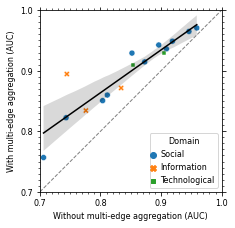

In [4]:
auc_values = data[[xlabel, ylabel]].values.flatten()
lim = (.6, 1)

fontsize=8
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.3,3.3), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
  'lines.linewidth': 1,
#   'lines.markersize': 4,
  'legend.handlelength': .1,
  'font.family': 'sans-serif',
  'font.sans-serif': 'Helvetica',
  'savefig.transparent': True
}

with plt.rc_context(rc):
  ax = sns.scatterplot(data=data, x=xlabel, y=ylabel, hue='Scientific domain', 
                  style='Scientific domain')
  sns.regplot(data=data, x=xlabel, y=ylabel, scatter=False, color='black', ax=ax)
  ax.axline((0,0), (1,1), ls='--', c='grey')
  ax.axis('scaled')
  ax.axis([.7, 1, .7, 1])

  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  plt.tight_layout()
  ax.legend(title='Domain', loc='lower right')
  plt.savefig('code/figures/output/Fig6.pdf')